In [1]:
# unzip 'library.zip'
unzip("library3.zip")
#zip('library3.zip','library')
# muda o diretorio da library
.libPaths("library")

In [ ]:
library(tidyverse)
library(tidymodels)
tidymodels_prefer()

#install.packages('rpart.plot')
library(rpart.plot) # para visualisar as arvores de decições

# Arvore de decisões

As arvores de decisões são algoritmos simples, porem muito eficientes em classificar. Podendo ser usado para regressões, porem não como a mesma eficiência.

São baseadas em "ifelse" para estabelecer divisões nos conjuntos de dados, essa divisão é baseada em qual valor ou classe entre as variáveis preditoras estabelece a melhor redução da entropia. Por meio de dois índices para classificação:




1.   Gini (CART): 1-∑(p)², onde `p` é a probabilidade dos elementos serem dividos em clases distintas.


2.   Ganho de informação (C4.5):-∑plog2(p)

E RSS ∑(y-y')², para regressões


Vamos ao exemplo da contruçãoo de uma arvore de decisão usando os dados `iris`

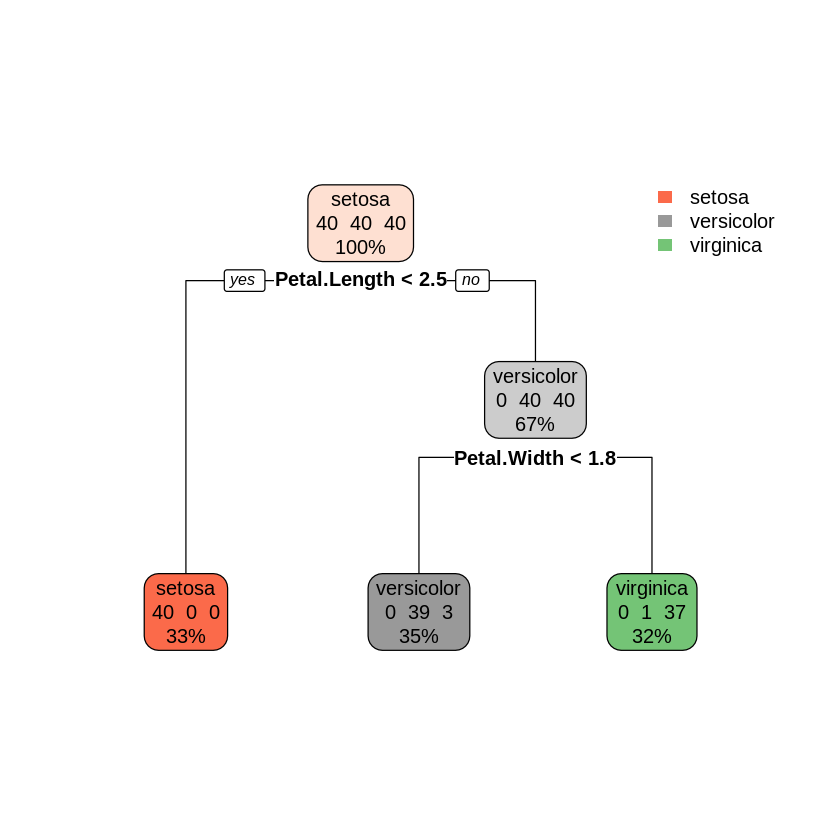

In [3]:

# transformar não numericas em fatores
iris <- as_tibble(iris) %>%
  mutate(across(where(~ n_distinct(.) < 10), as.factor))

# vamos fazer um split inicial stratificando com o "Species"
set.seed(2024)
iris_split <- initial_split(iris, prop = 0.80, strata = "Species")
iris_train <- training(iris_split)
iris_test  <-  testing(iris_split)

# definindo o modelo de arvore de decisão em modo de classificação
decision_tree_model <-
  decision_tree() %>%
  set_engine('rpart') %>%
  set_mode('classification') # classificação ou "regression" para regressão

# para fins didaticos neste exemplo não vamos usar o workflow, para poder visualisar a arvore
# definição do workflow
#dt_wflow <-
 # workflow() %>%
 # add_model(decision_tree_model) %>%
  #add_formula(Species~.)

#dt_fit = fit(dt_wflow, cars_train)
dt_fit = decision_tree_model %>% fit(Species~., iris_train)

#plotar a arvore gerada
rpart.plot(dt_fit$fit,type=2,extra=101,roundint=FALSE)

In [12]:
metricas = metric_set(accuracy, f_meas) # defino as metricas

# vamos prever os dados para cada grupo e ver as metricas
augment(dt_fit,new_data = iris_train) %>%
  metricas(truth = Species, estimate = .pred_class)

augment(dt_fit,new_data = iris_test) %>%
  metricas(truth = Species, estimate = .pred_class)

augment(dt_fit,new_data = iris_test) %>%
  conf_mat(truth = Species, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9666667
f_meas,macro,0.9666458


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9333333
f_meas,macro,0.9326599


            Truth
Prediction   setosa versicolor virginica
  setosa         10          0         0
  versicolor      0         10         2
  virginica       0          0         8

Vamos utilisar o dados do titanic para termos mais profundidade.

Observe que temos que definir os parametros de parada de crescimento:



1.   custo de complexidade (cost_complexity=0.01)
2.   profundaida da arvore (tree_depth=6)
3.   Tamanho minimo da folha (min_n=2)



parsnip model object

n= 571 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 571 232 0 (0.5936953 0.4063047)  
   2) Sex=male 360  73 0 (0.7972222 0.2027778) *
   3) Sex=female 211  52 1 (0.2464455 0.7535545)  
     6) Pclass=3 83  38 0 (0.5421687 0.4578313)  
      12) Age>=38.5 9   0 0 (1.0000000 0.0000000) *
      13) Age< 38.5 74  36 1 (0.4864865 0.5135135)  
        26) Age>=5.5 61  28 0 (0.5409836 0.4590164) *
        27) Age< 5.5 13   3 1 (0.2307692 0.7692308) *
     7) Pclass=1,2 128   7 1 (0.0546875 0.9453125) *

Warning message:
“Cannot retrieve the data used to build the model (so cannot determine roundint and is.binary for the variables).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”


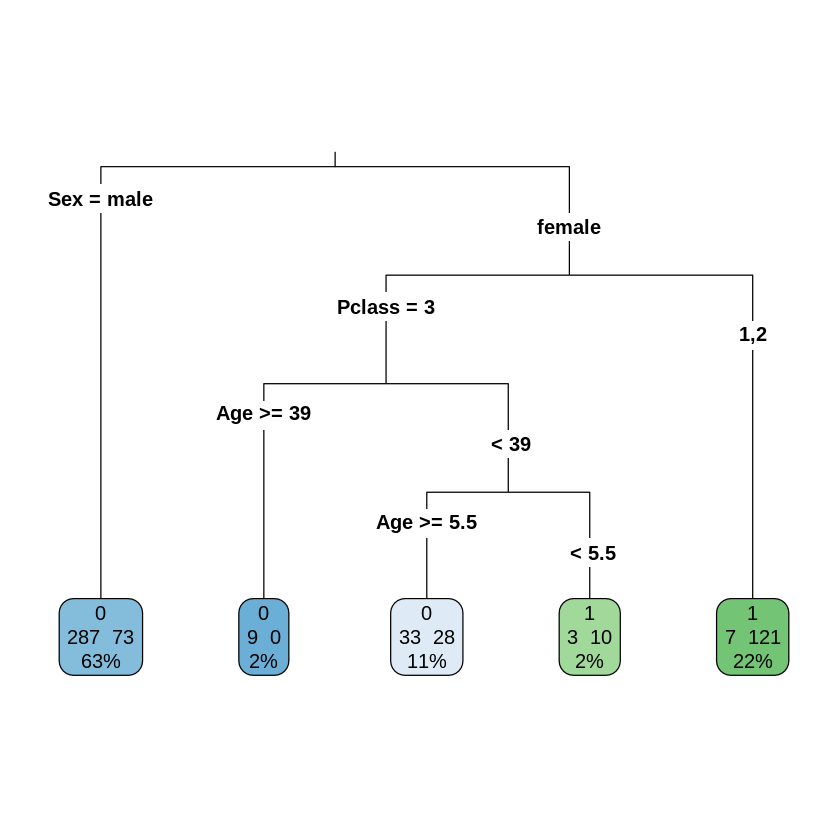

In [5]:
titanic=read.csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

titanic = titanic %>%
  mutate(across(where(~ n_distinct(.) < 10), as.factor)) %>% na.omit()

set.seed(2024)

titanic_split = initial_split(titanic, prop = 0.80, strata = "Survived")
df_train = training(titanic_split)
df_test  =  testing(titanic_split)

# neste exemplo vou deixar livre a arvore para crescer quanto a sua profundidade
decision_tree_model <-
  decision_tree(cost_complexity=0.01,tree_depth = 18,min_n = 2) %>%
  set_engine('rpart') %>%
  set_mode('classification')

dt_fit = decision_tree_model %>% fit(Survived~Age+Pclass+Sex, df_train)
dt_fit



rpart.plot(dt_fit$fit,type=3,extra=101)



In [27]:
augment(dt_fit,new_data = df_train) %>%
  cars_metrics(truth = Survived, estimate = .pred_class)

augment(dt_fit,new_data = df_test) %>%
  cars_metrics(truth = Survived, estimate = .pred_class)

augment(dt_fit,new_data = df_train) %>%
roc_auc(truth = Survived,.pred_0)

augment(dt_fit,new_data = df_test) %>%
roc_auc(truth = Survived,.pred_0)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8056042
f_meas,binary,0.8556567


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7832168
f_meas,binary,0.8410256


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.8109933


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.7787018


Vamos obter por meio do gráfico `plotcp`, qual foi o parâmetro de parada atingido.

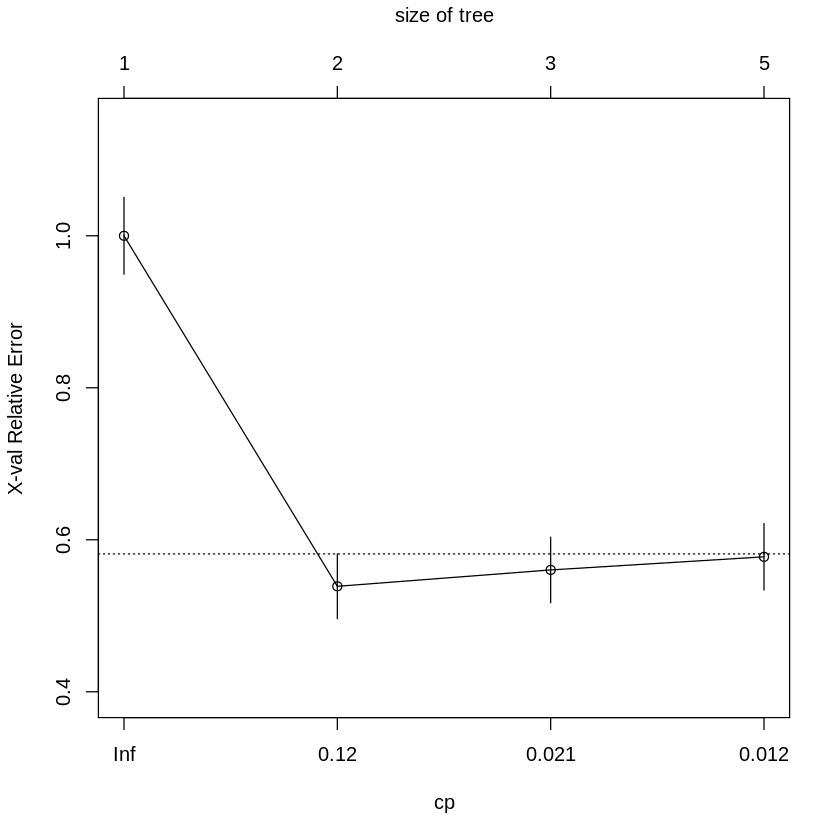

In [26]:
plotcp(dt_fit$fit)

Note que este gráfico pode nos auxiliar a definir a complexidade a ser limitada, para que não ocorra um overfiting, uma boa escolha é optar pelo ponto assim que o erro relativo estabilizar (0.021).

Warning message:
“Cannot retrieve the data used to build the model (so cannot determine roundint and is.binary for the variables).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”


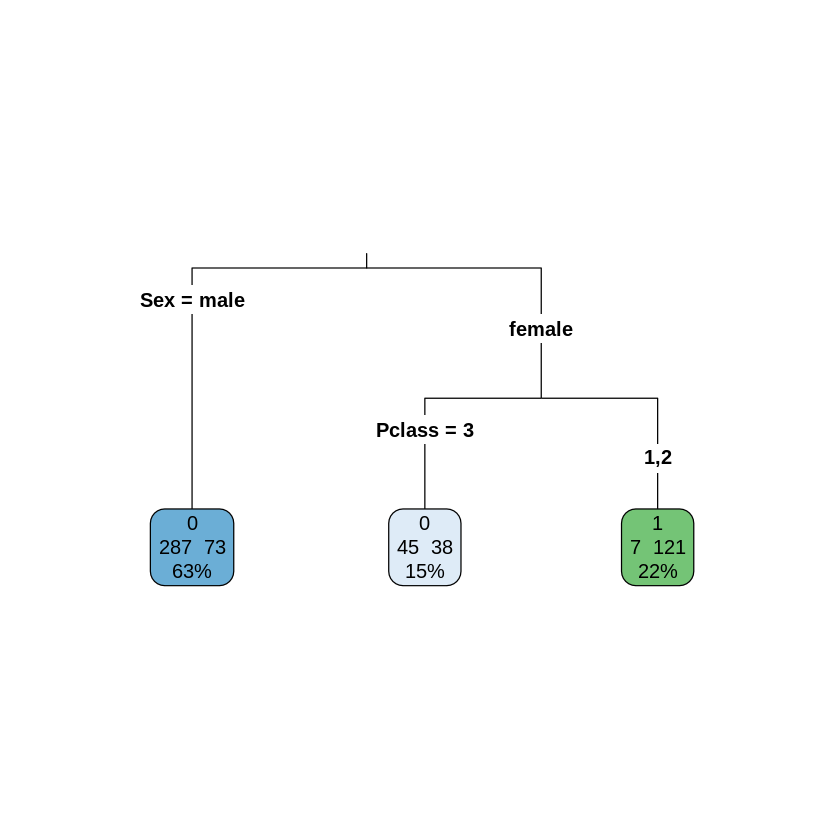

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7933450
f_meas,binary,0.8491049


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7832168
f_meas,binary,0.8426396


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.7989014


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.7845842


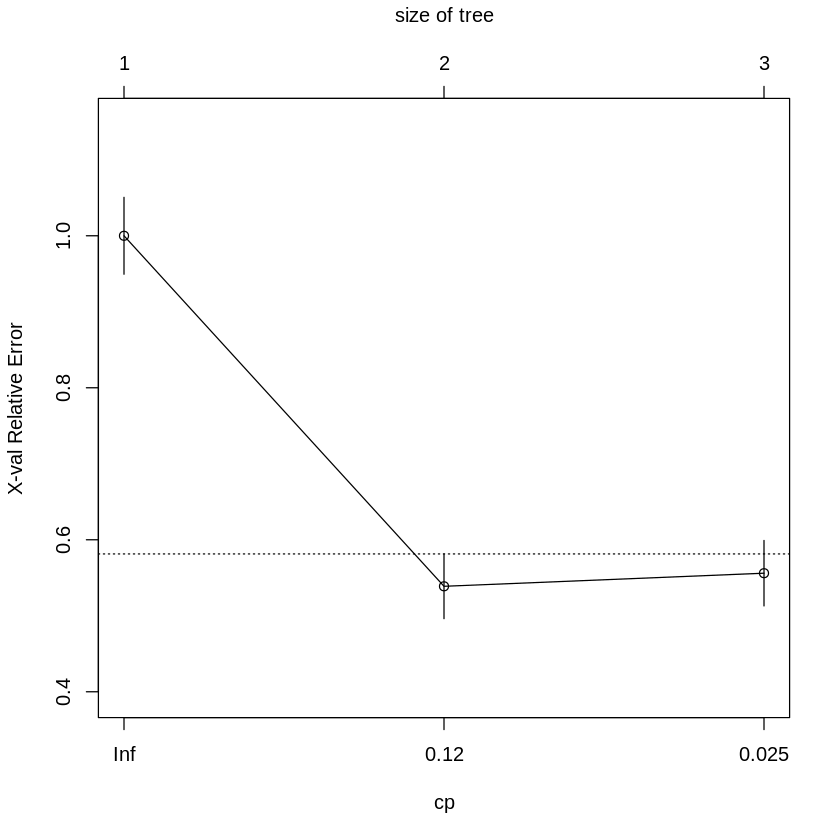

In [28]:
decision_tree_model <-
  decision_tree(cost_complexity=0.021) %>%
  set_engine('rpart') %>%
  set_mode('classification')

dt_fit = decision_tree_model %>% fit(Survived~Age+Pclass+Sex, df_train)

rpart.plot(dt_fit$fit,type=3,extra=101)
plotcp(dt_fit$fit)

augment(dt_fit,new_data = df_train) %>%
  cars_metrics(truth = Survived, estimate = .pred_class)

augment(dt_fit,new_data = df_test) %>%
  cars_metrics(truth = Survived, estimate = .pred_class)

augment(dt_fit,new_data = df_train) %>%
roc_auc(truth = Survived,.pred_0)

augment(dt_fit,new_data = df_test) %>%
roc_auc(truth = Survived,.pred_0)

Esse processo de redução da dimenção da arvore por meio de ajuste da complexidade da arvore se chama de **poda**.

### Bagging tree

O processo de arvores ensacadas funciona com um processo interno de reamostragem via bootstrap, no qual para cada conjunto de reamostragem é treinada uma arvore independente, no final todas votam, para classificação a classe é escolhida pela Moda, para regressão a media.

In [31]:
#install.packages('baguette')
library('baguette') # pacote necssario para o modelo

bag_tree_model <-
  bag_tree(tree_depth=3) %>%
  set_engine('rpart') %>%
  set_mode('classification')


# definição do workflow

dt_wflow <-
  workflow() %>%
  add_model(bag_tree_model) %>%
  add_formula(Survived~Age+Pclass+Sex)

dt_fit = fit(dt_wflow, df_train)

augment(dt_fit,new_data = df_train) %>%
  cars_metrics(truth = Survived, estimate = .pred_class)

augment(dt_fit,new_data = df_test) %>%
  cars_metrics(truth = Survived, estimate = .pred_class)

augment(dt_fit,new_data = df_train) %>%
roc_auc(truth = Survived,.pred_0)

augment(dt_fit,new_data = df_test) %>%
roc_auc(truth = Survived,.pred_0)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8196147
f_meas,binary,0.8571429


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7902098
f_meas,binary,0.8314607


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.8752289


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.8486815


### Floresta Aleatória (Random Forest)

A floresta aleatória funciona de maneira similar ao floresta ensacadas, a diferença é que agora temos um parâmetro `mtry` que é responsável por remover um numero de variáveis aleatórias de cada nó, fazendo que tenha uma aleatoriedade ainda maior, retirando o peso de variáveis dominantes como neste exemplo o sexo do passageiro.
Outro ponto de diferença é o tamanho das arvores que podem variar bastante pela ausência de limitador de complexidade e tamanho da arvore.
temos dois engines para a floresta aleatória, o randomforest para conjuntos menores e ranger que é otimizado para grandes conjuntos.


`mtry` por recomendação tem o valor da raiz quadrada do numero de variáveis para classificação e 1/3 das variáveis para regressões.
`trees`, parametro para definir o numero de arvores geradas
`min_n`, tamanho minimo de menbros nas folhas.
Tem um desempenho superior ao bagging tree para dados de maior dimensionalidade.

In [33]:
#install.packages('randomForest')
rf_model <-
  rand_forest() %>%
  set_engine('randomForest') %>%
  set_mode('classification')

rf_wflow <-
  workflow() %>%
  add_model(rf_model) %>%
  add_formula(Survived~Age+Pclass+Sex)

dt_fit = fit(rf_wflow, df_train)


augment(dt_fit,new_data = df_train) %>%
  cars_metrics(truth = Survived, estimate = .pred_class)

augment(dt_fit,new_data = df_test) %>%
  cars_metrics(truth = Survived, estimate = .pred_class)

augment(dt_fit,new_data = df_train) %>%
roc_auc(truth = Survived,.pred_0)

augment(dt_fit,new_data = df_test) %>%
roc_auc(truth = Survived,.pred_0)


Installing package into ‘/content/library’
(as ‘lib’ is unspecified)



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8213660
f_meas,binary,0.8657895


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7902098
f_meas,binary,0.8453608


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.8961131


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.8473631


# Boost Tree
Modelo similar ao random forest, porem agora as arvores são dependentes, onde o erro é propagada para a próxima arvore que tenta corrigi-lo. Este modelo  quando bem ajustado evitando o overffiteng é superior aos demais.
Este modelo possui diversos parâmetros a serem ajustados, que veremos mais a frente como otimizá-los


In [9]:
#install.packages('xgboost')
bt_model <-
  boost_tree(learn_rate=0.3,tree_depth = 6,trees=15) %>%
  set_engine('xgboost') %>%
  set_mode('classification')

bt_wflow <-
  workflow() %>%
  add_model(bt_model) %>%
  add_formula(Survived~Age+Pclass+Sex)

dt_fit = fit(bt_wflow, df_train)

metricas = metric_set(accuracy, f_meas)
augment(dt_fit,new_data = df_train) %>%
  metricas(truth = Survived, estimate = .pred_class)

augment(dt_fit,new_data = df_test) %>%
  metricas(truth = Survived, estimate = .pred_class)

augment(dt_fit,new_data = df_train) %>%
roc_auc(truth = Survived,.pred_0)

augment(dt_fit,new_data = df_test) %>%
roc_auc(truth = Survived,.pred_0)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8633975
f_meas,binary,0.8892045


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7762238
f_meas,binary,0.8160920


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.9359742


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.8510142


Vamos tentar ajustar o modelo na mão, com base em como corrigimos as outras arvores de decisões, para evitar esse provável overfiting.

Um modo de ver se a nossa configuração esta melhor, afim de evitar surpresas quando for fazer o teste ou na hora de escolher modelos. É utilizar o processo de validação. ao invés de usar o conjunto de Treino, visto que o modelos complexo como xboost tende a se ajustar bem ao dados.

In [48]:
# agora vamos criar o conjunto de validação
cv_folds <- vfold_cv(df_train, v = 5, strata = Survived)

# fit de reamostragem
cv_fit=fit_resamples(bt_wflow,cv_folds)

cv_fit %>% collect_metrics()



.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.8055779,5,0.009050546,Preprocessor1_Model1
brier_class,binary,0.1415857,5,0.004626274,Preprocessor1_Model1
roc_auc,binary,0.8551009,5,0.008308897,Preprocessor1_Model1


## Processo de tune dos hiperparametros



1. definir na hora de especificar o modelo quais os parâmetros a serem tunados
2. criar uma grade de conjunto de valores a serem testados.
3. Tunar os parâmetros para identificar o melhor ajuste (cuidado com o overfiting)



In [109]:
bt_model =boost_tree(
  trees = 300,               # Número de árvores
  tree_depth = tune(),        # Profundidade da árvore
  learn_rate = tune(),        # Taxa de aprendizado
  sample_size = tune()        # Subsample (fração de amostras)
) %>%
  set_engine("xgboost") %>%
  set_mode("classification")




bt_wflow <-
  workflow() %>%
  add_model(bt_model) %>%
  add_formula(Survived~Age+Pclass+Sex)


# agora vamos criar o conjunto de validação
cv_folds <- vfold_cv(df_train, v = 5, strata = Survived)

#criando o espaço dos hipermarametros

# Criando um grid de hiperparâmetros
#xgb_grid <- grid_regular(
 # tree_depth(range = c(3, 10)),
  #learn_rate(),
   #sample_prop(range = c(0.5, 1.0)), # tem um erro de configuração no pacote por isso do sample_prop, não sample size
  #levels = 5 # Define 5 níveis para cada hiperparâmetro
#)

xgb_grid <-expand_grid(
  tree_depth = c(3, 5, 7),
  learn_rate = c(0.2, 0.3, 0.4),
  sample_size = c(0.6, 0.8, 1.0)
)

# Criando um grid de hiperparâmetros randomico
#xgb_grid <- grid_random(
#  tree_depth(range = c(3, 10)),
#  learn_rate(),
#   sample_prop(range = c(0.5, 1.0)), # tem um erro de configuração no pacote por isso do sample_prop, não sample size
#  size = 10
#)


head(xgb_grid)






tree_depth,learn_rate,sample_size
<dbl>,<dbl>,<dbl>
3,0.2,0.6
3,0.2,0.8
3,0.2,1.0
3,0.3,0.6
3,0.3,0.8
3,0.3,1.0


Vamos fazer o tune do modelo

In [64]:
#
xgb_tuned <- tune_grid(
  bt_wflow,
  resamples = cv_folds,
  grid = xgb_grid,
  metrics = metric_set(roc_auc, accuracy)  # Avaliando AUC e acurácia
)

xgb_tuned %>%
  show_best(metric = "roc_auc")

tree_depth,learn_rate,sample_size,.metric,.estimator,mean,n,std_err,.config
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,0.2,0.6,roc_auc,binary,0.8489684,5,0.007252643,Preprocessor1_Model01
3,0.2,1.0,roc_auc,binary,0.8478635,5,0.006625823,Preprocessor1_Model03
3,0.2,0.8,roc_auc,binary,0.8445792,5,0.004137496,Preprocessor1_Model02
3,0.3,0.8,roc_auc,binary,0.8436773,5,0.006644497,Preprocessor1_Model05
5,0.2,0.6,roc_auc,binary,0.8432155,5,0.005868243,Preprocessor1_Model10


In [76]:
xgb_tuned %>%
  collect_metrics() %>% filter(.metric=="roc_auc") %>%
  arrange(std_err)

tree_depth,learn_rate,sample_size,.metric,.estimator,mean,n,std_err,.config
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,0.2,0.8,roc_auc,binary,0.8445792,5,0.004137496,Preprocessor1_Model02
5,0.3,0.6,roc_auc,binary,0.8341804,5,0.005386192,Preprocessor1_Model13
5,0.2,0.6,roc_auc,binary,0.8432155,5,0.005868243,Preprocessor1_Model10
3,0.3,0.6,roc_auc,binary,0.8369893,5,0.005914450,Preprocessor1_Model04
7,0.4,1.0,roc_auc,binary,0.8391108,5,0.006086046,Preprocessor1_Model27
7,0.2,1.0,roc_auc,binary,0.8392593,5,0.006554929,Preprocessor1_Model21
3,0.2,1.0,roc_auc,binary,0.8478635,5,0.006625823,Preprocessor1_Model03
7,0.3,1.0,roc_auc,binary,0.8378683,5,0.006626283,Preprocessor1_Model24
3,0.3,0.8,roc_auc,binary,0.8436773,5,0.006644497,Preprocessor1_Model05


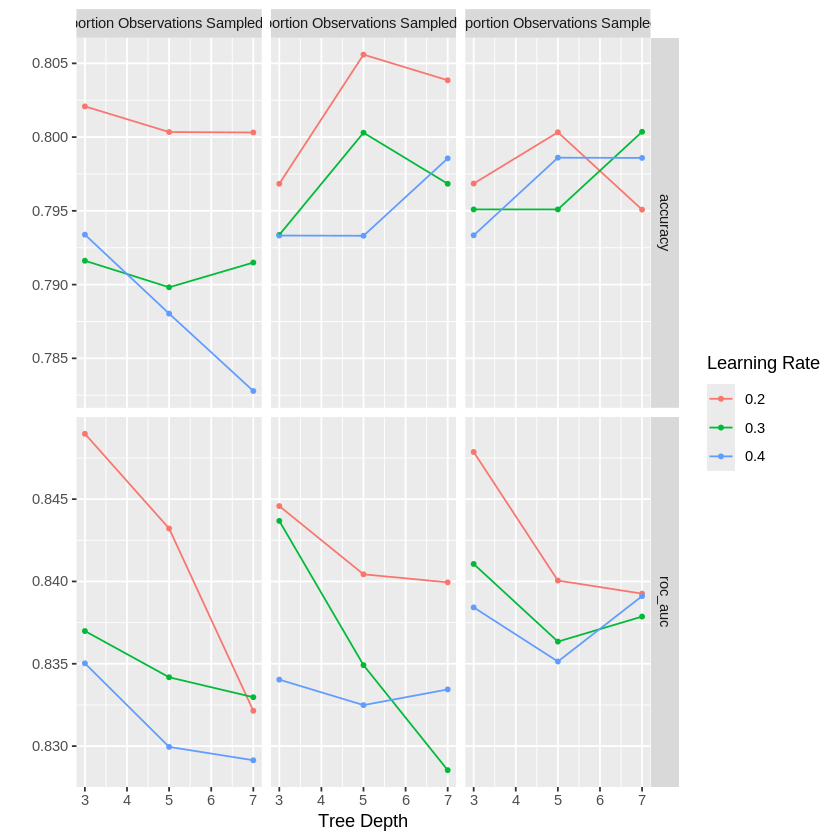

In [77]:
# Gráfico dos resultados
autoplot(xgb_tuned)

Vamos escolher o melhor combinação de parametros

In [116]:
best_params <- xgb_tuned %>%
  select_best(metric = "roc_auc")
print(best_params)

# caso outros
#best_params = list(tree_depth = 3, learn_rate = 0.4,sample_size=1)

# A tibble: 1 × 4
  tree_depth learn_rate sample_size .config              
       <dbl>      <dbl>       <dbl> <chr>                
1          3        0.2         0.6 Preprocessor1_Model01


Agora mos finalizar o workflow com os parametros escolhidos

In [118]:


# Atualiza o workflow com os melhores hiperparâmetros
final_bt_wflow <- finalize_workflow(
  bt_wflow,
  best_params  # Parâmetros selecionados no ajuste
)

final_bt_wflow

dt_fit <- fit(final_bt_wflow, data = df_train)



augment(dt_fit,new_data = df_train) %>%
  cars_metrics(truth = Survived, estimate = .pred_class)

augment(dt_fit,new_data = df_test) %>%
  cars_metrics(truth = Survived, estimate = .pred_class)


augment(dt_fit,new_data = df_train) %>%
roc_auc(truth = Survived,.pred_0)

augment(dt_fit,new_data = df_test) %>%
roc_auc(truth = Survived,.pred_0)

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Formula
Model: boost_tree()

── Preprocessor ────────────────────────────────────────────────────────────────
Survived ~ Age + Pclass + Sex

── Model ───────────────────────────────────────────────────────────────────────
Boosted Tree Model Specification (classification)

Main Arguments:
  trees = 300
  tree_depth = 3
  learn_rate = 0.2
  sample_size = 0.6

Computational engine: xgboost 


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8756567
f_meas,binary,0.9001406


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8181818
f_meas,binary,0.8539326


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.9483776


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.8452333


In [127]:
# agora vamos criar o conjunto de validação
cv_folds <- vfold_cv(df_train, v = 5, strata = Survived)

# fit de reamostragem
cv_fit=fit_resamples(final_bt_wflow ,cv_folds)

cv_fit %>% collect_metrics()


.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.7934181,5,0.01624996,Preprocessor1_Model1
brier_class,binary,0.1518340,5,0.01116984,Preprocessor1_Model1
roc_auc,binary,0.8467906,5,0.01451214,Preprocessor1_Model1


### Rede neurais

Dentro do tidymodels, podemos configurar um modelo de redes neurais com uma camada escondida.

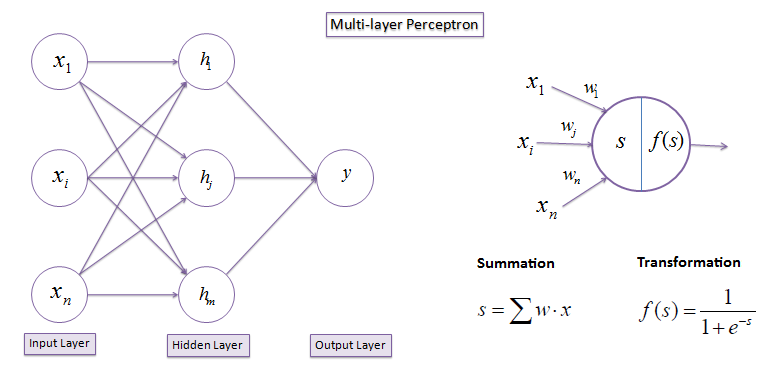

Os parâmetros:

Hidden_units: quantas unidades de percptrons vão ter na camada escondida.
Epochs: quantas vezes o modelo vai ajustar os pesos.
penality: valor da regularização L2 (ridge)

In [122]:
mlp_model <-
  mlp(hidden_units = 5, epochs = 100) %>%
  set_engine('nnet') %>%
  set_mode('classification')

mlp_recip= df_train %>% recipe(Survived~Age+Pclass+Sex)%>%
  step_dummy(all_factor_predictors())

mlp_wflow <-
  workflow() %>%
  add_model(mlp_model) %>%
  add_formula(Survived~Age+Pclass+Sex)
  #add_recipe(mlp_recip)

mlp_fit = fit(mlp_wflow, df_train)
mlp_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Formula
Model: mlp()

── Preprocessor ────────────────────────────────────────────────────────────────
Survived ~ Age + Pclass + Sex

── Model ───────────────────────────────────────────────────────────────────────
a 4-5-1 network with 31 weights
inputs: Age Pclass2 Pclass3 Sexmale 
output(s): ..y 
options were - entropy fitting 

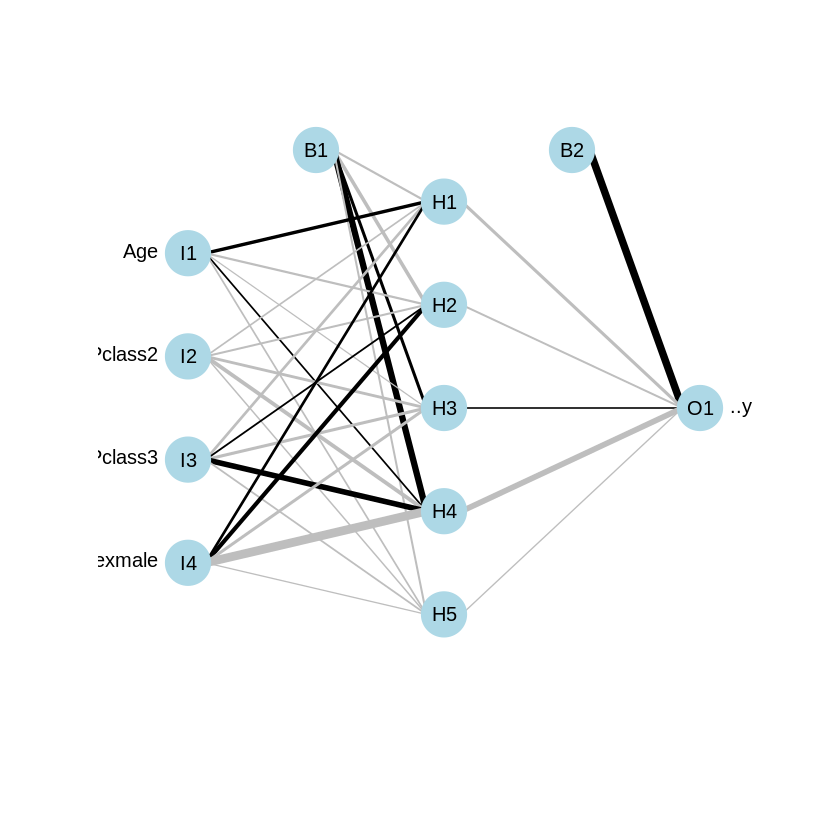

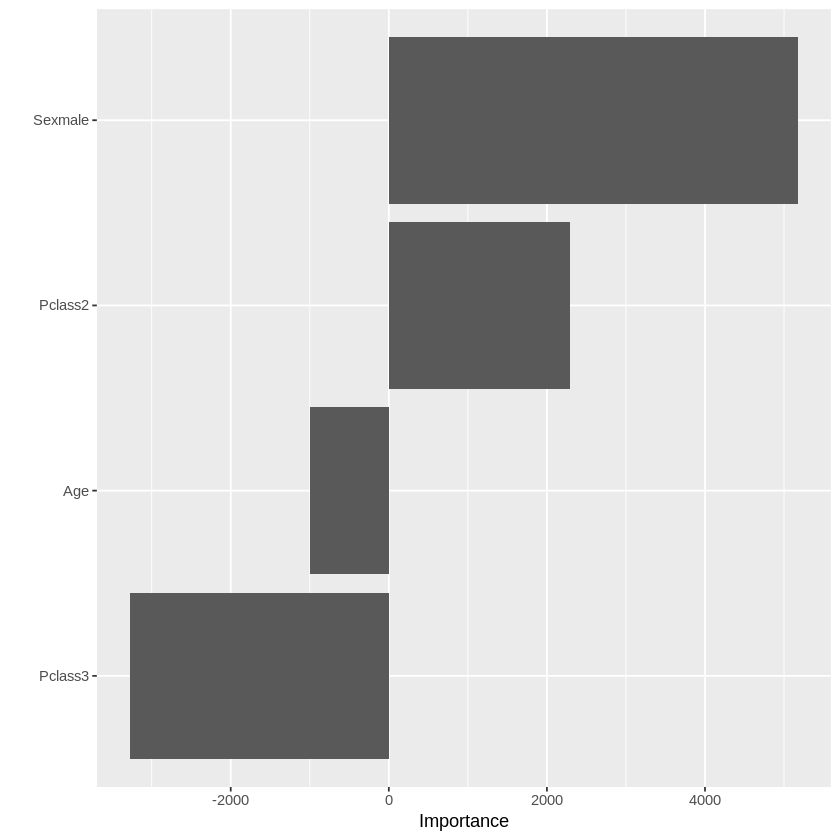

In [123]:
#install.packages('NeuralNetTools')
#install.packages("vip")
library(NeuralNetTools)
library(vip) # pacote para obhter a variavel de importancia

mlp_fit %>% extract_fit_engine() %>% plotnet()
mlp_fit %>% extract_fit_engine() %>% vip()

In [124]:
augment(mlp_fit,new_data = df_test) %>%
  cars_metrics(truth = Survived, estimate = .pred_class)

augment(mlp_fit,new_data = df_train) %>%
  cars_metrics(truth = Survived, estimate = .pred_class)

augment(mlp_fit,new_data = df_train) %>%
roc_auc(truth = Survived,.pred_0)

augment(mlp_fit,new_data = df_test) %>%
roc_auc(truth = Survived,.pred_0)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8041958
f_meas,binary,0.8510638


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8091068
f_meas,binary,0.8517007


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.8737222


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.8237323


In [128]:


# fit de reamostragem
cv_fit=fit_resamples(mlp_wflow ,cv_folds)

cv_fit %>% collect_metrics()

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.8107631,5,0.01616283,Preprocessor1_Model1
brier_class,binary,0.1607519,5,0.00545506,Preprocessor1_Model1
roc_auc,binary,0.8653619,5,0.02154094,Preprocessor1_Model1


###WORK FLOW SET

Como testar varias combinações de modelos e recipes:

wflow_id,.config,preproc,model,.metric,.estimator,mean,n,std_err
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>
recipe2_mlp,Preprocessor1_Model1,recipe,mlp,roc_auc,binary,0.8211867,5,0.023914202
recipe2_bt,Preprocessor1_Model1,recipe,boost_tree,roc_auc,binary,0.8212632,5,0.014276286
recipe_bag,Preprocessor1_Model1,recipe,bag_tree,roc_auc,binary,0.8226081,5,0.015176836
recipe2_bag,Preprocessor1_Model1,recipe,bag_tree,roc_auc,binary,0.8342303,5,0.012071293
recipe_mlp,Preprocessor1_Model1,recipe,mlp,roc_auc,binary,0.8480329,5,0.007381187
recipe_bt,Preprocessor1_Model1,recipe,boost_tree,roc_auc,binary,0.8628543,5,0.017736208


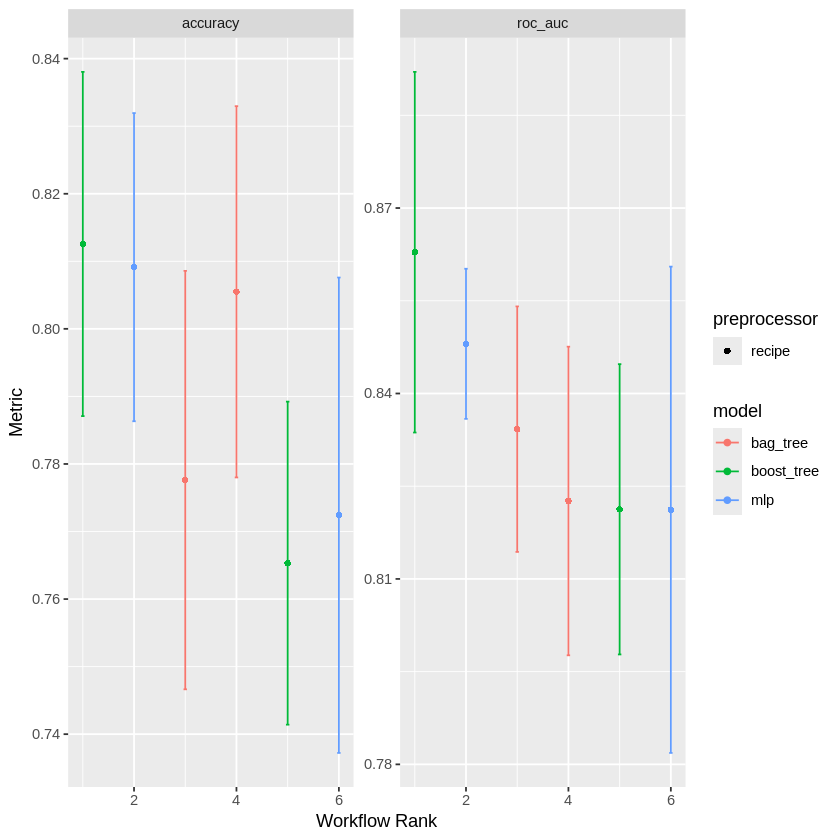

In [166]:
# definição das receitas:

mlp_recip= df_train %>% recipe(Survived~Age+Pclass+Sex)%>%
  step_dummy(all_factor_predictors())

mlp_recip2= df_train %>% recipe(Survived~Age+Fare+Sex)%>%
  step_dummy(all_factor_predictors())


#definição dos modelos
mlp_model <-
  mlp(hidden_units = 5, epochs = 100) %>%
  set_engine('nnet') %>%
  set_mode('classification')

bt_model <-
  boost_tree(learn_rate=0.4,tree_depth = 3) %>%
  set_engine('xgboost') %>%
  set_mode('classification')

bag_tree_model <-
  bag_tree(tree_depth=3) %>%
  set_engine('rpart') %>%
  set_mode('classification')

# definir um workflow geral
workf_tudo=workflow_set(preproc = list(recipe=mlp_recip,recipe2=mlp_recip2),models =  list(mlp=mlp_model,bt=bt_model,bag=bag_tree_model),cross = T)

# ver qual o workflow apresenta o melhor combinação.
model_eval=workflow_map(workf_tudo,
fn="fit_resamples",
resamples=cv_folds,
metrics=metric_set(roc_auc, accuracy))

collect_metrics(model_eval) %>% filter(.metric=="roc_auc") %>% arrange(mean)
autoplot(model_eval)